# ANN - Artificial Neural Network

In [3]:
import pandas as pd
from fastai.tabular.all import *

## Clean and preprocess data

In [2]:
churn = pd.read_csv('data/Churn_Modelling.csv')
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [5]:
# drop columns with no predictive value
churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [8]:
churn.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [60]:
dep = 'Exited'
churn[dep] = churn[dep].astype(np.float32)
cont, cat = cont_cat_split(churn, max_card=1, dep_var=dep)
splits = RandomSplitter(seed=42)(churn)

cont, cat, splits

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'],
 ((#8000) [5886,911,6853,2031,7391,5680,4363,1262,7372,3804...],
  (#2000) [7542,8214,3698,2841,8086,2550,2282,7599,1462,2026...]))

In [61]:
tp = TabularPandas(
    churn,
    procs=[Categorify, FillMissing, Normalize], 
    cat_names=cat,
    cont_names=cont,
    y_names=dep,
    splits=splits
)

tp.show(3)

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5886,Germany,Male,607.0,40.0,5.0,90594.546875,1.0,0.0,1.0,181598.250000,0.0
911,Spain,Female,648.0,53.0,6.0,111201.406250,1.0,1.0,1.0,121542.289062,0.0
6853,France,Female,685.0,43.0,1.0,132667.171875,1.0,1.0,1.0,41876.980469,0.0


In [62]:
# show preprocessed data
tp.items.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5886,-0.448960,2,2,0.098127,-0.009028,0.223146,-0.913194,-1.538046,0.978481,1.424672,0.0
911,-0.024888,3,1,1.333474,0.336526,0.553118,-0.913194,0.650175,0.978481,0.378760,0.0
6853,0.357810,1,1,0.383207,-1.391242,0.896843,-0.913194,0.650175,0.978481,-1.008660,0.0


In [63]:
# dataloader with given batch size
# show shapes of data being input into model

dls = tp.dataloaders(bs=256)
[t.shape for t in dls.one_batch()], len(cat), len(cont)

([torch.Size([256, 2]), torch.Size([256, 8]), torch.Size([256, 1])], 2, 8)

# Create ANN model class with pytorch

In [82]:
class ANN(nn.Module):
    def __init__(self, num_inputs, layers):
        super().__init__()
        self.num_inputs = num_inputs
        self.layers = layers
        
        all_layers = [num_inputs] + layers
        modules = []
        
        for num_nodes_1, num_nodes_2 in zip(all_layers, all_layers[1:]):
            modules += [
                nn.BatchNorm1d(num_nodes_1),
                nn.Linear(num_nodes_1, num_nodes_2),
                nn.ReLU()
            ]
            
        modules += [
            nn.BatchNorm1d(all_layers[-1]),
            nn.Linear(all_layers[-1], 1),
            nn.Sigmoid()
        ]
        
        self.model = nn.Sequential(*modules)
    
    def forward(self, cat, cont):
        X = torch.cat([cat, cont], axis=1)
        return self.model(X)


def acc(x, y):
    return (x.round()==y).float().mean()

In [83]:
num_inputs = len(cont) + len(cat)
model = ANN(num_inputs, [6, 6])

learn = Learner(dls, model, loss_func=F.binary_cross_entropy, metrics=acc)

In [84]:
print(model)

ANN(
  (model): Sequential(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=10, out_features=6, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=6, out_features=6, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=6, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


SuggestedLRs(valley=0.019054606556892395)

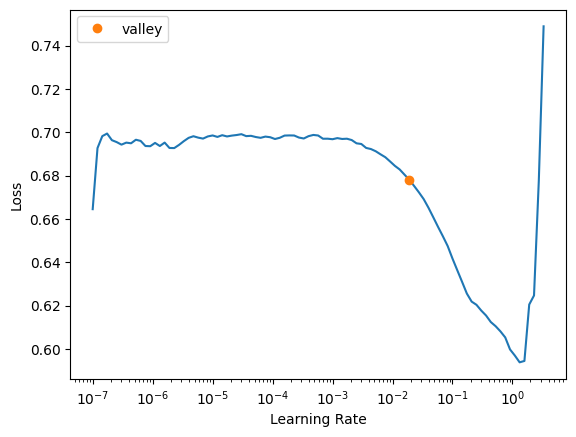

In [85]:
learn.lr_find()

In [86]:
learn.fit_one_cycle(7, lr_max=0.01, wd=0.1)

epoch,train_loss,valid_loss,acc,time
0,0.660678,0.609159,0.777000,00:00
1,0.570914,0.455196,0.804500,00:00
2,0.487762,0.397655,0.842000,00:00
3,0.441295,0.368681,0.849500,00:00
4,0.409982,0.351659,0.860500,00:00
5,0.388538,0.347005,0.865500,00:00
6,0.375796,0.346685,0.860500,00:00


# Try different ANN architectures

In [89]:
archs = [
    [6, 6],
    [20, 10],
    [50, 20],
    [100, 50],
    [10, 10, 10],
]

for layers in archs:
    print(layers)
    model = ANN(num_inputs, layers)
    learn = Learner(dls, model, loss_func=F.binary_cross_entropy, metrics=acc)
    learn.fit_one_cycle(10, lr_max=0.01, wd=0.1)

[6, 6]


epoch,train_loss,valid_loss,acc,time
0,0.631943,0.592058,0.791500,00:00
1,0.570906,0.465418,0.802500,00:00
2,0.495351,0.386921,0.832500,00:00
3,0.436455,0.354047,0.854500,00:00
4,0.398288,0.345293,0.861500,00:00
5,0.376752,0.335846,0.866500,00:00
6,0.366166,0.338482,0.863500,00:00
7,0.359466,0.336157,0.861500,00:00
8,0.354225,0.335660,0.865500,00:00
9,0.352299,0.335303,0.863500,00:00


[20, 10]


epoch,train_loss,valid_loss,acc,time
0,0.759756,0.700086,0.533000,00:00
1,0.657512,0.438814,0.842000,00:00
2,0.509458,0.338830,0.865000,00:00
3,0.428610,0.330473,0.863500,00:00
4,0.386298,0.328124,0.863000,00:00
5,0.363380,0.326712,0.869000,00:00
6,0.347956,0.324105,0.869000,00:00
7,0.339948,0.324667,0.866500,00:00
8,0.334692,0.324912,0.870500,00:00
9,0.331396,0.323947,0.868500,00:00


[50, 20]


epoch,train_loss,valid_loss,acc,time
0,0.619352,0.535885,0.775500,00:00
1,0.515221,0.396806,0.833500,00:00
2,0.430771,0.345198,0.856000,00:00
3,0.387110,0.328892,0.866500,00:00
4,0.363728,0.333286,0.855000,00:00
5,0.349716,0.333728,0.859000,00:00
6,0.341295,0.331376,0.863500,00:00
7,0.334412,0.329726,0.861000,00:00
8,0.328737,0.328014,0.860000,00:00
9,0.324736,0.327905,0.860000,00:00


[100, 50]


epoch,train_loss,valid_loss,acc,time
0,0.673999,0.544640,0.759500,00:00
1,0.535984,0.369751,0.851500,00:00
2,0.439854,0.338318,0.865000,00:00
3,0.391294,0.340454,0.866500,00:00
4,0.366405,0.332773,0.866500,00:00
5,0.353486,0.333596,0.860500,00:00
6,0.340780,0.336693,0.864500,00:00
7,0.331409,0.329548,0.860000,00:00
8,0.322477,0.329379,0.863500,00:00
9,0.315503,0.329167,0.863000,00:00


[10, 10, 10]


epoch,train_loss,valid_loss,acc,time
0,0.620060,0.560740,0.799000,00:00
1,0.535473,0.425083,0.832000,00:00
2,0.450162,0.355631,0.853500,00:00
3,0.405786,0.353633,0.858500,00:00
4,0.380902,0.350408,0.855500,00:00
5,0.366877,0.342104,0.862500,00:00
6,0.357522,0.339927,0.863000,00:00
7,0.353250,0.336447,0.862500,00:00
8,0.349930,0.335931,0.866000,00:00
9,0.346253,0.335704,0.865000,00:00


# Making predictions

In [130]:
customer = pd.DataFrame({
    'CreditScore': 600,
    'Geography': 'France',
    'Gender': 'Male',
    'Age': 40,
    'Tenure': 3,
    'Balance': 60000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 50000,
}, index=[0])

customer

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,600,France,Male,40,3,60000,2,1,1,50000


In [131]:
# Apply all preprocessing to customer and predict if Exited.
# There is a 2.64% chance this customer leaves the bank.

test_dl = learn.dls.test_dl(customer)
learn.get_preds(dl=test_dl)

(tensor([[0.0264]]), None)

In [167]:
test_dl = learn.dls.test_dl(churn.loc[splits[1]])
pred, targ = learn.get_preds(dl=test_dl)
pred.shape, targ.shape

(torch.Size([2000, 1]), torch.Size([2000, 1]))

In [169]:
pred_final = (pred>0.5).float()
pred_final

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [171]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(targ, pred_final)

array([[1552,   42],
       [ 228,  178]])

In [173]:
accuracy_score(targ, pred_final)

0.865